# Video Vision Transformer

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498), [Ayush Thakur](https://twitter.com/ayushthakur0) (equal contribution)<br>
**Date created:** 2022/01/12<br>
**Last modified:**  2022/01/12<br>
**Description:** A Transformer-based architecture for video classification.

## Introduction

Videos are sequences of images. Let's assume you have an image
representation model (CNN, ViT, etc.) and a sequence model
(RNN, LSTM, etc.) at hand. We ask you to tweak the model for video
classification. The simplest approach would be to apply the image
model to individual frames, use the sequence model to learn
sequences of image features, then apply a classification head on
the learned sequence representation.
The Keras example
[Video Classification with a CNN-RNN Architecture](https://keras.io/examples/vision/video_classification/)
explains this approach in detail. Alernatively, you can also
build a hybrid Transformer-based model for video classification as shown in the Keras example
[Video Classification with Transformers](https://keras.io/examples/vision/video_transformers/).

In this example, we minimally implement
[ViViT: A Video Vision Transformer](https://arxiv.org/abs/2103.15691)
by Arnab et al., a **pure Transformer-based** model
for video classification. The authors propose a novel embedding scheme
and a number of Transformer variants to model video clips. We implement
the embedding scheme and one of the variants of the Transformer
architecture, for simplicity.

This example requires TensorFlow 2.6 or higher, and the `medmnist`
package, which can be installed by running the code cell below.

In [1]:
!pip install -qq medmnist

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.12.0 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.


## Imports

In [2]:
import os
import io
import imageio
import medmnist
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

ModuleNotFoundError: No module named 'medmnist'

## Hyperparameters

The hyperparameters are chosen via hyperparameter
search. You can learn more about the process in the "conclusion" section.

In [ ]:
# DATA
DATASET_NAME = "organmnist3d"
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (28, 28, 28, 1)
NUM_CLASSES = 11

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 10

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

## Dataset

For our example we use the
[MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification](https://medmnist.com/)
dataset. The videos are lightweight and easy to train on.

In [ ]:

def download_and_prepare_dataset(data_info: dict):
    """Utility function to download the dataset.

    Arguments:
        data_info (dict): Dataset metadata.
    """
    data_path = keras.utils.get_file(origin=data_info["url"], md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        # Get videos
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        # Get labels
        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels),
    )


# Get the metadata of the dataset
info = medmnist.INFO[DATASET_NAME]

# Get the dataset
prepared_dataset = download_and_prepare_dataset(info)
(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos, test_labels) = prepared_dataset[2]

32657407/32657407 [==============================] - 51s 2us/step


### `tf.data` pipeline

In [ ]:

@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
testloader = prepare_dataloader(test_videos, test_labels, "test")

## Tubelet Embedding

In ViTs, an image is divided into patches, which are then spatially
flattened, a process known as tokenization. For a video, one can
repeat this process for individual frames. **Uniform frame sampling**
as suggested by the authors is a tokenization scheme in which we
sample frames from the video clip and perform simple ViT tokenization.

| ![uniform frame sampling](https://i.imgur.com/aaPyLPX.png) |
| :--: |
| Uniform Frame Sampling [Source](https://arxiv.org/abs/2103.15691) |

**Tubelet Embedding** is different in terms of capturing temporal
information from the video.
First, we extract volumes from the video -- these volumes contain
patches of the frame and the temporal information as well. The volumes
are then flattened to build video tokens.

| ![tubelet embedding](https://i.imgur.com/9G7QTfV.png) |
| :--: |
| Tubelet Embedding [Source](https://arxiv.org/abs/2103.15691) |

In [ ]:

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)

        # *****PRINT LAYER OUTPUT *****
        #print(tf.shape(flattened_patches.shape))
        #print(flattened_patches)

        return flattened_patches


## Positional Embedding

This layer adds positional information to the encoded video tokens.

In [ ]:

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens


## Video Vision Transformer

The authors suggest 4 variants of Vision Transformer:

- Spatio-temporal attention
- Factorized encoder
- Factorized self-attention
- Factorized dot-product attention

In this example, we will implement the **Spatio-temporal attention**
model for simplicity. The following code snippet is heavily inspired from
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).
One can also refer to the
[official repository of ViViT](https://github.com/google-research/scenic/tree/main/scenic/projects/vivit)
which contains all the variants, implemented in JAX.

In [ ]:

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


## Train

In [ ]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


model = run_experiment()
model.summary()

Epoch 1/10
31/31 [==============================] - 18s 70ms/step - loss: 2.4100 - accuracy: 0.1307 - top-5-accuracy: 0.6111 - val_loss: 2.2180 - val_accuracy: 0.2422 - val_top-5-accuracy: 0.7081
Epoch 2/10
31/31 [==============================] - 1s 35ms/step - loss: 2.0878 - accuracy: 0.2058 - top-5-accuracy: 0.7531 - val_loss: 1.9416 - val_accuracy: 0.2298 - val_top-5-accuracy: 0.7391
Epoch 3/10
31/31 [==============================] - 1s 33ms/step - loss: 1.9232 - accuracy: 0.2500 - top-5-accuracy: 0.8282 - val_loss: 1.7017 - val_accuracy: 0.3168 - val_top-5-accuracy: 0.8696
Epoch 4/10
31/31 [==============================] - 1s 33ms/step - loss: 1.7617 - accuracy: 0.2932 - top-5-accuracy: 0.8786 - val_loss: 1.5232 - val_accuracy: 0.3416 - val_top-5-accuracy: 0.9379
Epoch 5/10
31/31 [==============================] - 1s 33ms/step - loss: 1.6091 - accuracy: 0.3467 - top-5-accuracy: 0.9043 - val_loss: 1.4992 - val_accuracy: 0.3168 - val_top-5-accuracy: 0.9503
Epoch 6/10
31/31 [======

In [ ]:
!pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
import pytorch_model_summary as ms
from fastai.vision.all import *

ms.summary(model(), torch.zeros(28, 28, 28, 1), show_input=True)
'''

'\nimport pytorch_model_summary as ms\nfrom fastai.vision.all import *\n\nms.summary(model(), torch.zeros(28, 28, 28, 1), show_input=True)\n'

## Inference

In [ ]:
NUM_SAMPLES_VIZ = 25
testsamples, labels = next(iter(testloader))
testsamples, labels = testsamples[:NUM_SAMPLES_VIZ], labels[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos = []

for i, (testsample, label) in enumerate(zip(testsamples, labels)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample.numpy() * 255).astype("uint8"), "GIF", fps=5)
        videos.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.numpy().astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
for i in range(NUM_SAMPLES_VIZ):
    ib = ipywidgets.widgets.Image(value=videos[i], width=100, height=100)
    true_class = info["label"][str(ground_truths[i])]
    pred_class = info["label"][str(preds[i])]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

1/1 [==============================] - 0s 32ms/step


GridBox(children=(VBox(children=(HTML(value="'T: pancreas | P: bladder'"), Box(children=(Image(value=b'GIF89a\…

## Final thoughts

With a vanilla implementation, we achieve ~79-80% Top-1 accuracy on the
test dataset.

The hyperparameters used in this tutorial were finalized by running a
hyperparameter search using
[W&B Sweeps](https://docs.wandb.ai/guides/sweeps).
You can find out our sweeps result
[here](https://wandb.ai/minimal-implementations/vivit/sweeps/66fp0lhz)
and our quick analysis of the results
[here](https://wandb.ai/minimal-implementations/vivit/reports/Hyperparameter-Tuning-Analysis--VmlldzoxNDEwNzcx).

For further improvement, you could look into the following:

- Using data augmentation for videos.
- Using a better regularization scheme for training.
- Apply different variants of the transformer model as in the paper.

We would like to thank [Anurag Arnab](https://anuragarnab.github.io/)
(first author of ViViT) for helpful discussion. We are grateful to
[Weights and Biases](https://wandb.ai/site) program for helping with
GPU credits.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/video-vision-transformer) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/video-vision-transformer-CT).

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


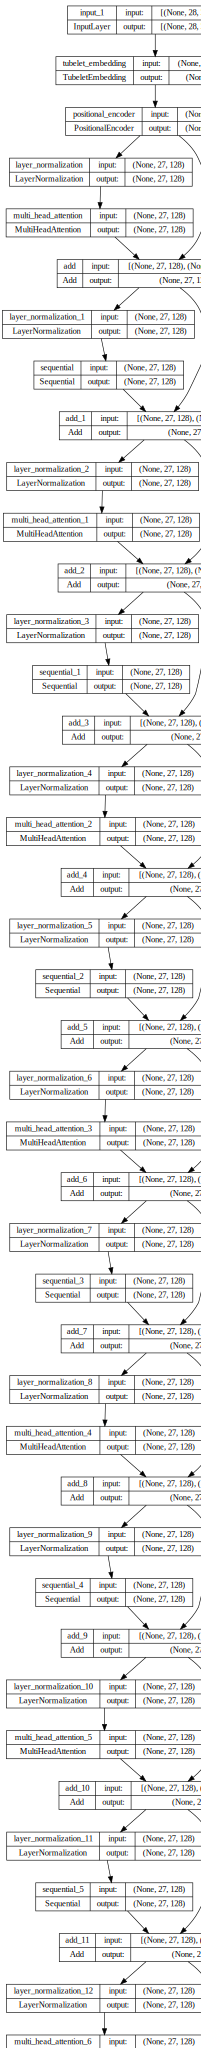

In [ ]:
!pip install graphviz
!pip install pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# or save as png

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)